# Predicting Monthly Electricity Consumption (Machine Learning)

Project : Predicting Monthly Electricity Consumption 

Build a Machine learning model for each sector :
1. Split the data into train, validation and test set
2. Use random forest regression to select feature by feature of important 
3. Try dropping feature pairs with high correlation such as number of customer and population, income and GSP
4. Use TPOT to find the best model
5. Train the model on the training+validation set and predict on the test set
6. Analyze model performance by state



## Table of Contents
- [Predicting Residential Consumption](#res)
    - [Analyze Residential Consumption Model](#ana_res)
- [Predicting Industrial Consumption](#ind)
    - [Analyze Industrial Consumption Model](#ana_ind)
- [Predicting Commercial Consumption](#com)
    - [Analyze Commercial Consumption Model](#ana_com) 
- [Combine models and Analyze models performance by state](#analyze)



Add the prediction from the three sectors to get the total consumption. 

# Import libraries and define functions

In [1]:
# import the library
import sys
import feather
import pickle
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import (RandomizedSearchCV, GridSearchCV,
                                    train_test_split, TimeSeriesSplit, KFold)
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler,FunctionTransformer
from tpot import TPOTRegressor
from tpot.builtins import StackingEstimator,ZeroCount
from sklearn.externals import joblib
from copy import copy

from IPython.display import display
import folium

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [2]:
def three_split(df,y):
    '''split data into train, validation and test 
    this is a time series data, thus no shuffle
    '''
    test_idxs = int(df.shape[0]*0.85)
    X_test = df.iloc[test_idxs:]
    y_test = y[test_idxs:]
    val_idxs = int(df.shape[0]*0.85*0.75)
    
    X_trn = df.iloc[:val_idxs]
    y_trn = y[:val_idxs]

    X_val = df.iloc[val_idxs:test_idxs]
    y_val = y[val_idxs:test_idxs]
    
    return (X_trn,y_trn,X_val,y_val,X_test,y_test)

In [3]:
def two_split(df,y):
    '''split data into train, validation and test 
    this is a time series data, thus no shuffle
    '''
    test_idxs = int(df.shape[0]*0.85)
    X_test = df.iloc[test_idxs:]
    y_test = y[test_idxs:]
    
    X_trn = df.iloc[:test_idxs]
    y_trn = y[:test_idxs]
    
    return (X_trn,y_trn,X_test,y_test)

In [4]:
def do_search(X_trn,y_trn):
    ''' randomize search for randomforest regressor
    return the best estimator'''
    # rf 
    m = RandomForestRegressor(n_jobs=-1, random_state=42)
    
    param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
              'max_features' : range(2,X_trn.shape[1]),
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}
    
    #hyper parameter tuning
    search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=5, random_state=40)
    
    search.fit(X_trn,y_trn)
    print(search.best_params_, search.best_score_)
    
    return search.best_estimator_

In [5]:
from scipy.cluster import hierarchy as hc

def make_dendo(df):
    '''create a dendogram showing redundant features'''
    corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))
    
    for i in range(corr.shape[0]):
        corr[i,i] = 1
    
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr, method='average')
    fig = plt.figure(figsize=(10,7))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
    plt.show()

In [6]:
def print_score(m,Xtrn,ytrn,Xval,yval):
    '#print score print  rmse, and r2 score and return these scores'
    res = [mean_squared_error(m.predict(Xtrn), ytrn),
           mean_squared_error(m.predict(Xval), yval), 
           m.score(Xtrn, ytrn),
           m.score(Xval, yval)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    #print('Training loss \t Val loss \t Train R2 \t Val R2')
    print(res)
    return res

In [7]:
def plot_score(m,res,val=False):
    
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    if val:
        x = ['train','val','test']
        c = ['royalblue','orange','red']
        res = np.insert(res,2,mean_squared_error(m.predict(X_test),y_test))
        res = np.append(res,m.score(X_test,y_test))
        print(res)
    else:
        x = ['train', 'test']
        c = ['royalblue','red']

    ax[0].bar(x=x, height=res[:len(x)],width=0.5,edgecolor ='black',color =c)
    ax[0].set_title('RMSE loss')
    
    for i in range(len(x)):
        ax[0].text(s=f'{res[i].round(2)}',x=i, y=res[i].round(2)*0.7,horizontalalignment='center')
  
    ax[1].bar(x=x, height=res[len(x):],width=0.5,edgecolor ='black',color =c)
    ax[1].set_title('R2 Score')
    
    for i in range(len(x)):
        ax[1].text(s=f'{res[len(x)+i].round(2)}',x=i, y=res[len(x)+i].round(2)*0.7,horizontalalignment='center')   

In [8]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia':'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [9]:
def do_prediction(combine,m,fi_cols,pre_col,split=0.85):
    ''' Input
    combine: dataframe with all data
    fi_cols: columns to use for the model 
    m: trained model 
    split: percent data for test set 
    return y_predict and r-square 
    '''
    df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
    df = df[fi_cols]
    X_trn,y_trn,X_test,y_test = two_split(df,y)
    
    y_predict = m.predict(X_test)
    score = m.score(X_test,y_test)
    return (y_predict, score)

In [10]:
from matplotlib import cm

def get_color(series,cmap=cm.Blues):
    ''' obtain hex color map for each value'''
    vmin = series.min()
    vmax = series.max()
    #normalize item number values to colormap
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    #colormap values = viridis, jet, spectral
    state_colors = [cmap(norm(value)) for value in series.values]
    state_colors = [str(cm.colors.to_hex(color)) for color in state_colors]
    return state_colors

In [11]:
# load state location json
with open('statemap.json','r') as fp:
    statemap = json.load(fp)
    
def draw_state(subplot, name,cfill='lightblue',cedge='turquoise',alphafill=0.5,alphaedge=1):
    """   
    Automatically draws a filled shape representing the state in
    subplot (ax object).  
    name is abbreviation of the state.
    cfill is the fill color
    cedge is the edge color
    alphafill is the fill transparency
    alphaedge is the edge transparency
    """
    polygons = statemap[name]
    for polygon in polygons:
        xs, ys = zip(*polygon)
        subplot.fill(xs, ys, c=cfill,alpha=alphafill)
        subplot.plot(xs, ys, c=cedge,alpha=alphaedge)

In [334]:
def score_by_state(col,predict,score,**kwargs):
    '''input the y_test column, predicted value and score
    plot the r2 score by state. plot in subplot if passed ax argument
    
    return df containing prediction and score_by_state df  
    '''
    data = combine.iloc[-len(predict):][['Year-Month','State',col]].copy()
    data[col+'_predict'] = predict
    
    score_by_state = []
    for state in data['State'].unique():
        temp = data[data['State']==state]
        state_score = r2_score(temp[col],temp[col+'_predict'])
        score_by_state.append([state,state_score])
    
    # all over all score
    score_by_state.append(['All',score])
    # turn it into df
    score_by_state = pd.DataFrame(score_by_state,columns=['State','Score']).sort_values('Score')
    # add color columns
    score_by_state['color'] = get_color(score_by_state['Score'],cm.coolwarm_r)
    # the last columns is red 
    score_by_state.iloc[-1,-1] = '#de2d26'
    if bool(kwargs):
        ax = kwargs['ax']
    else:
        _,ax = plt.subplots(figsize=(10, 3))
    
    ax.bar(score_by_state['State'],score_by_state['Score'],color=score_by_state['color'],edgecolor='black')
    ax.tick_params(labelrotation=90)
    #plt.xticks(rotation=90)
    ax.set_title(col+' prediction performance by state')
    
    return data, score_by_state


In [13]:
import matplotlib.dates as mdates

def plot_predict(pred_df, score_state,col):
    ''' plot the prediction/actual value vs time 
    for states with 3 best prediction and 3 worst prediction
    '''
    # select state
    states = score_state['State'][:3].to_list() + score_state['State'][-4:-1].to_list()
    states.reverse()
    # extract data
    data = pred_df[pred_df['State'].isin(states)]
    data = data.set_index('Year-Month')
    
    fig, ax = plt.subplots(6,1,figsize=(10, 5),sharex=True)

    for i, state in enumerate(states):
        temp = data[data['State']==state]
        ax[i].plot(temp[col],c='royalblue')
        ax[i].plot(temp[col+'_predict'],c='orange')
        ax[i].legend(['actual','predict'], loc='upper right')
        ax[i].axes.set_ylabel(state)
        ax[i].axes.set_yticklabels([])

    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
    fig.suptitle(col+'Monthly Prediction by State')

In [14]:
def performance_feature(pred_df,score_state):
    ''' Analyze relationship between model performance by state and features 
    input predict_df contain time-series prediction/actual data
    score_state: df containing model performance by state 
    '''
    data = combine[['Year-Month','State','Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions','Density']]
    # merge with prediction data
    data = pred_df.merge(data,on=['Year-Month','State'])
    
    # generate per capita column
    data['Income_per_cap'] = data['Income']/data['Pop']
    data['GSP_per_cap'] = data['GSP']/data['Pop']
    
    data = data.drop('Year-Month',axis=1).groupby('State',as_index=False).max()
    data = data.merge(score_state, on='State')
    
    make_dendo(data)

# Load Data

In [342]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'
# load the data 
combine = pd.read_csv(cleanfolder+'combine.csv').dropna()
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
# set State and Regions columns as category 
combine['State'] = combine['State'].astype('category')
combine['Regions'] = combine['Regions'].astype('category')
combine.head()

,Year,Month,State,Sale_RES,Sale_COM,Sale_IND,Sale_OTH,Sale_ALL,Price_RES,Price_COM,...,Cooling_deg_days,Pop,Income,UR,GSP,CPI,Regions,Year-Month,Density,Sale_ALL_no_OTH
1,1990,1,AL,2070.09,820.42,2099.55,53.95,5044.01,5.96,6.64,...,21.0,4036.801,64029.4,6.7,71085.0,132.0,East South Central,1990-01-01,0.030775,4990.06
2,1990,1,AR,1026.32,474.99,782.49,47.60,2331.40,7.06,6.52,...,5.0,2347.535,34283.2,6.7,38109.0,132.0,West South Central,1990-01-01,0.017419,2283.80
3,1990,1,AZ,1396.50,1081.79,809.80,151.06,3439.15,7.83,7.64,...,0.0,3668.417,63546.7,5.2,69322.0,132.0,Mountain,1990-01-01,0.012469,3288.09
4,1990,1,CA,6168.01,6011.77,4454.66,869.56,17504.01,9.68,8.46,...,0.0,29863.502,640724.9,5.2,788322.0,132.0,Pacific Contiguous,1990-01-01,0.074017,16634.44
5,1990,1,CO,1046.80,1158.96,545.39,58.78,2809.94,6.81,5.62,...,0.0,3294.308,65348.5,5.4,74206.0,132.0,Mountain,1990-01-01,0.012272,2751.15


In [343]:
combine.tail()

,Year,Month,State,Sale_RES,Sale_COM,Sale_IND,Sale_OTH,Sale_ALL,Price_RES,Price_COM,...,Cooling_deg_days,Pop,Income,UR,GSP,CPI,Regions,Year-Month,Density,Sale_ALL_no_OTH
17590,2018,9,VT,165.66,172.50,114.40,0.00,452.56,17.95,15.11,...,25.0,627.688,33999.8,2.6,33845.8,258.429,New England,2018-09-01,0.026295,452.56
17591,2018,9,WA,2117.33,2301.72,2005.44,0.56,6425.05,9.91,8.63,...,8.0,7552.303,467144.7,4.4,568575.5,258.429,Pacific Contiguous,2018-09-01,0.043878,6424.49
17592,2018,9,WI,1666.02,1996.62,2094.15,0.02,5756.80,14.88,11.08,...,48.0,5826.461,299460.7,3.0,339100.4,258.429,East North Central,2018-09-01,0.041538,5756.79
17593,2018,9,WV,808.05,639.14,1131.73,0.00,2578.93,11.24,9.02,...,195.0,1809.837,75124.9,5.1,78345.0,258.429,South Atlantic,2018-09-01,0.029069,2578.92
17594,2018,9,WY,161.95,302.88,845.79,0.00,1310.62,12.23,9.75,...,23.0,579.018,35316.2,4.2,40994.6,258.429,Mountain,2018-09-01,0.002303,1310.62


In [12]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Year-Month', 'Density', 'Sale_ALL_no_OTH'],
      dtype='object')

How the data are split.
We have the data from Jan 1990 to Sept 2018.
For hyper parameter tuning and model searching in TPOT. The data were split into train (64%), validation(20%) and test(15%) sets using the function `three_split`. The model is retrained using the train+validation set using the function `two_split`. The test set is used to evaluate the model performance. 

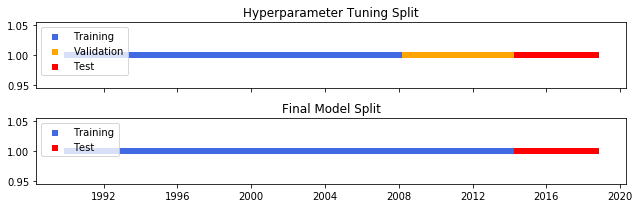

In [360]:
date = combine['Year-Month']
test_idxs = int(date.shape[0]*0.85)
date_test = date.iloc[test_idxs:]
val_idxs = int(date.shape[0]*0.85*0.75)
date_trn = date.iloc[:val_idxs]
date_val = date.iloc[val_idxs:test_idxs]

fig, ax = plt.subplots(2,1,figsize=(9, 3),sharex=True)
l1 = ax[0].scatter(date_trn, [1] * len(date_trn), c='royalblue', marker='_', lw=6)
l2 = ax[0].scatter(date_val, [1] * len(date_val), c='orange', marker='_', lw=6)
l3 = ax[0].scatter(date_test, [1] * len(date_test), c='red', marker='_', lw=6)
ax[0].legend([l1, l2, l3], ['Training', 'Validation','Test'],loc='upper left')


l1 = ax[1].scatter(date_trn, [1] * len(date_trn), c='royalblue', marker='_', lw=6)
l2 = ax[1].scatter(date_val, [1] * len(date_val), c='royalblue', marker='_', lw=6)
l3 = ax[1].scatter(date_test, [1] * len(date_test), c='red', marker='_', lw=6)
ax[1].legend([l1, l3], ['Training','Test'],loc='upper left')

ax[0].set_title('Hyperparameter Tuning Split')
ax[1].set_title('Final Model Split')

plt.tight_layout()

# Machine Learning

## Predicting Residential Consumption<a id='res'></a>

In [16]:
#predict column 
pre_col = 'Sale_RES'
use_col = ['Year', 'Month', 'State','Cus_RES','Price_RES', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI','Regions','Density']

skip_col = [x for x in combine.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the state column with 49 catergory
df, y, nas = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=51)

In [17]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m_res = do_search(X_trn,y_trn)

m_res.fit(X_trn,y_trn)

{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 27, 'max_depth': None, 'bootstrap': False} 0.9785090331005624


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=27, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=160, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[2725.654383501005, 151526.559219879, 0.9992987384031021, 0.9735636983078985]
[  2725.65438 151526.55922 317657.30255      0.9993       0.97356      0.95018]


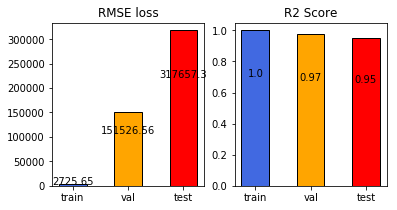

In [18]:
# print and plot train, validation and test score 
result = print_score(m_res,X_trn,y_trn,X_val,y_val)
plot_score(m_res,result,val=True)

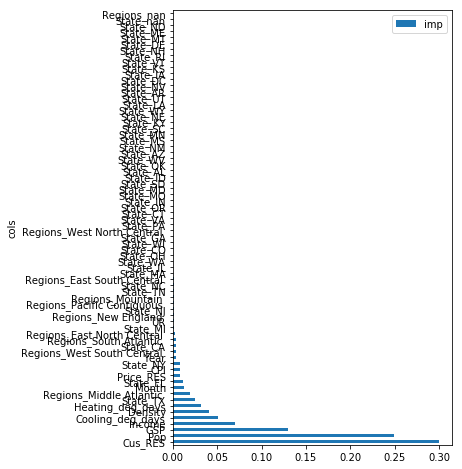

In [19]:
# calculate feature of importance
fi = rf_feat_importance(m_res, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,10))

In [33]:
# drop features with low importance 
to_drop = fi[fi.imp <0.01].cols
df_drop = df.drop(to_drop,axis=1)

In [22]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop,y)
m_res = do_search(X_trn,y_trn)

m_res.fit(X_trn,y_trn)

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 7, 'max_depth': None, 'bootstrap': False} 0.9729755356762316


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[3996.1523355412655, 177764.00175371708, 0.9989718622488483, 0.9689861447092109]
[  3996.15234 177764.00175 492775.14643      0.99897      0.96899      0.92271]


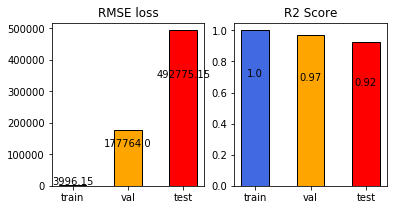

In [23]:
result = print_score(m_res,X_trn,y_trn,X_val,y_val)
plot_score(m_res, result,val=True)

In [34]:
df_drop.columns

Index(['Month', 'Cus_RES', 'Heating_deg_days', 'Cooling_deg_days', 'Pop',
       'Income', 'GSP', 'Density', 'State_FL', 'State_TX',
       'Regions_Middle Atlantic '],
      dtype='object')

Try dropping highly correlated pair

In [26]:
pairs = ['Cus_RES','Pop']
for col in pairs:
    X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop.drop(col,axis=1),y)
    m_res.fit(X_trn,y_trn)
    print('drop ',col)
    result = print_score(m_res,X_trn,y_trn,X_val,y_val)

drop  Cus_RES
[4154.789375054557, 282352.6580924138, 0.9989310478065151, 0.9507389325585731]
drop  Pop
[4429.800366354453, 160148.14983157645, 0.9988602924502634, 0.9720595199536214]


Can drop 'Pop' columns 

In [28]:
pairs = ['Income', 'GSP']
for col in pairs:
    X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop.drop(col,axis=1),y)
    m_res.fit(X_trn,y_trn)
    print('drop ',col)
    result = print_score(m_res,X_trn,y_trn,X_val,y_val)

drop  Income
[3913.680945459334, 170404.33279424897, 0.9989930806465503, 0.9702701600657807]
drop  GSP
[4218.142170227577, 183021.09224434817, 0.9989147482776457, 0.9680689587653835]


Can drop 'Income' columns 

In [35]:
df_drop = df_drop.drop(['Pop','Income'],axis=1)

[4874.343774608953, 176402.3316561472, 0.9988871603372603, 0.9723311278230257]


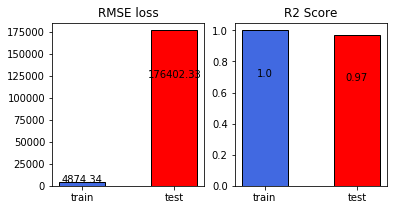

In [36]:
# split data into training, validation and test sets
X_trn,y_trn,X_test,y_test = two_split(df_drop,y)

m_res.fit(X_trn,y_trn)
# score
result = print_score(m_res,X_trn,y_trn,X_test,y_test)
plot_score(m_res, result,val=False)

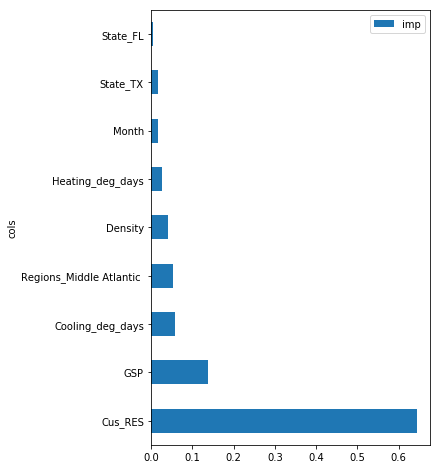

In [37]:
# calculate feature of importance
fi_res = rf_feat_importance(m_res, X_trn)
fi_res.plot('cols','imp',kind='barh',figsize=(5,8))

In [38]:
# save train model 
pickle.dump(m_res, open('model/res_model.pkl', 'wb'))
#sort fi df by X_trn columns order 
fi_res['cols'] = pd.Categorical(fi_res['cols'], X_trn.columns)
fi_res = fi_res.sort_values('cols')
# save feature of importance 
fi_res.to_csv('model/res_feature_importance.csv',index=False)

**TPOT** 

In [76]:
# load feature of importance 
fi_res = pd.read_csv('model/res_feature_importance.csv')
pre_col = 'Sale_RES'
df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
df = df[fi_res['cols']]
X_trn,y_trn,X_test,y_test = two_split(df,y)
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_trn, y_trn)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline_res.py')

Generation 1 - Current best internal CV score: -114729.24726232389
Generation 2 - Current best internal CV score: -114729.24726232389
Generation 3 - Current best internal CV score: -114729.24726232389
Generation 4 - Current best internal CV score: -114729.24726232389
Generation 5 - Current best internal CV score: -109514.3724223006

Best pipeline: ExtraTreesRegressor(MaxAbsScaler(LassoLarsCV(MinMaxScaler(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=1.0, min_samples_leaf=3, min_samples_split=12, n_estimators=100)), normalize=False)), bootstrap=False, max_features=1.0, min_samples_leaf=9, min_samples_split=20, n_estimators=100)
-135743.1403826239


Implementing TPOT model 

In [22]:
# load feature of importance 
fi_res = pd.read_csv('model/res_feature_importance.csv')
pre_col = 'Sale_RES'
df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
df = df[fi_res['cols']]
X_trn,y_trn,X_test,y_test = two_split(df,y)

[26493.599493487516, 141252.71617972894, 0.9939513645962613, 0.9778443781783699]


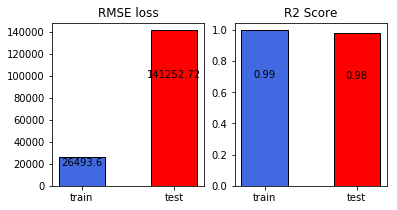

In [31]:
pipe_res = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=1.0, min_samples_leaf=3, min_samples_split=12, n_estimators=100)),
    MinMaxScaler(),
    StackingEstimator(estimator=LassoLarsCV(normalize=False,cv=5)),
    MaxAbsScaler(),
    ExtraTreesRegressor(bootstrap=False, max_features=1.0, min_samples_leaf=9, min_samples_split=20, n_estimators=100)
)

pipe_res.fit(X_trn,y_trn)
result = print_score(pipe_res,X_trn,y_trn,X_test,y_test)
plot_score(pipe_res, result,val=False)

In [33]:
#save the model 
joblib.dump(pipe_res, 'model/pipe_res.pkl')

['model/pipe_res.pkl']

### Analyze Residential Consumption Model <a id='ana_res'></a>

In [74]:
#load the model 
pipe_res = joblib.load('model/pipe_res.pkl')
# load feature of importance 
fi_res = pd.read_csv('model/res_feature_importance.csv')

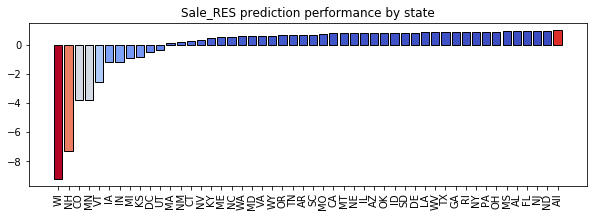

In [88]:
col = 'Sale_RES'
# analyzing the prediction result by state 
res_predict, res_score = do_prediction(combine,pipe_res,fi_res['cols'],col)
res_pred_df, score_state_res = score_by_state(col,res_predict,res_score)

For the state with low prediction score, is there any geological relationship with the score ?

Text(0.5, 1.0, 'Sale_RESModel Performance by State')

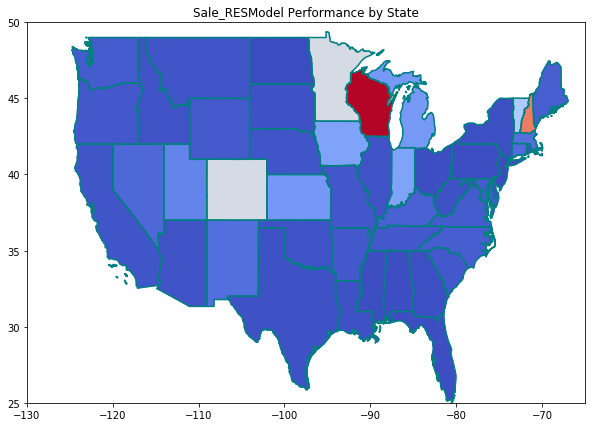

In [89]:
_,ax = plt.subplots(figsize=(10,7))

data = score_state_res.drop(score_state_res.index[-1])

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title(col + 'Model Performance by State')

Look at the time-series prediction

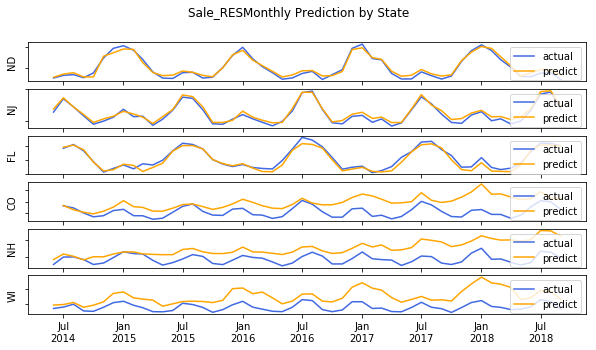

In [126]:
plot_predict(res_pred_df,score_state_res,col)

Any relationship between model performance by state and their features?

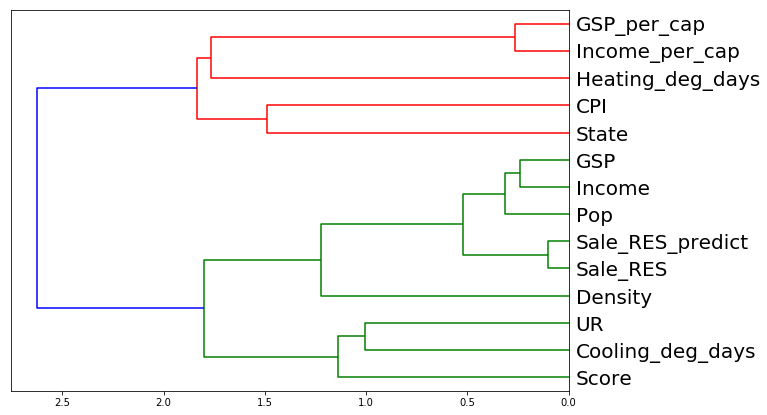

In [175]:
performance_feature(res_pred_df,score_state_res.drop('color',axis=1))

The model performance is related to the cooling degree days. This suggest that model perform poorly on northern states. 

## Predicting Industry Consumption <a id='ind'></a>

In [176]:
#predict column 
pre_col = 'Sale_IND'
use_col = ['Year', 'Month', 'State','Cus_IND','Price_IND', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI','Regions','Density']

skip_col = [x for x in combine.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the state column with 49 catergory
df, y, nas = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=49)

In [177]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m_ind = do_search(X_trn,y_trn)

m_ind.fit(X_trn,y_trn)

{'n_estimators': 120, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 37, 'max_depth': None, 'bootstrap': True} 0.9756042390581787


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=37, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[4383.667733340631, 87786.35992428048, 0.9982787483578606, 0.9623225390919148]
[  4383.66773  87786.35992 172306.32038      0.99828      0.96232      0.93344]


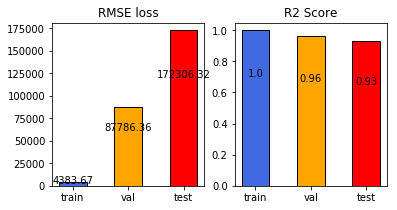

In [178]:
result = print_score(m_ind,X_trn,y_trn,X_val,y_val)
# train, validation and test set score 
plot_score(m_ind,result,val=True)

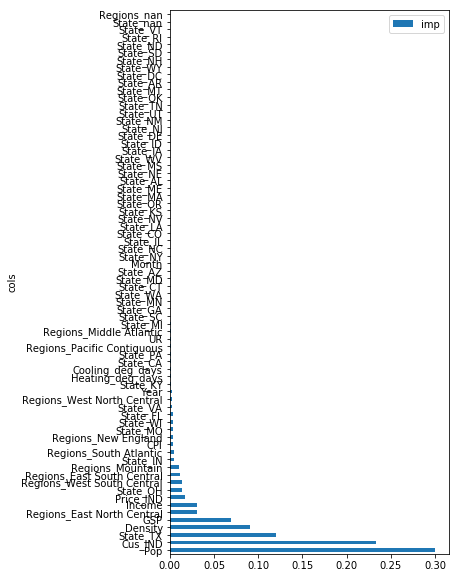

In [179]:
# calculate feature of importance
fi = rf_feat_importance(m_ind, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,10))

In [197]:
# drop features with low importance 
to_drop = fi[fi.imp <0.0005].cols
df_drop = df.drop(to_drop,axis=1)

In [189]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop,y)
m_ind = do_search(X_trn,y_trn)

m_ind.fit(X_trn,y_trn)

{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': None, 'bootstrap': True} 0.9761381409362421


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=180, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[3952.8148894507117, 102830.3724789435, 0.9984479231699536, 0.9558657251242555]
[  3952.81489 102830.37248 199167.39038      0.99845      0.95587      0.92306]


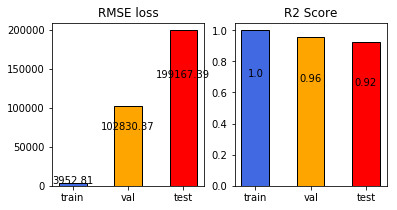

In [190]:
result= print_score(m_ind,X_trn,y_trn,X_val,y_val)
plot_score(m_ind, result,val=True)

In [191]:
df_drop.columns

Index(['Year', 'Month', 'Price_IND', 'Cus_IND', 'Heating_deg_days',
       'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP', 'CPI', 'Density',
       'State_AZ', 'State_CA', 'State_CT', 'State_FL', 'State_GA', 'State_IN',
       'State_KY', 'State_MD', 'State_MI', 'State_MN', 'State_MO', 'State_NY',
       'State_OH', 'State_PA', 'State_SC', 'State_TX', 'State_VA', 'State_WA',
       'State_WI', 'Regions_East North Central', 'Regions_East South Central',
       'Regions_Middle Atlantic', 'Regions_Mountain', 'Regions_New England',
       'Regions_Pacific Contiguous', 'Regions_South Atlantic',
       'Regions_West North Central', 'Regions_West South Central'],
      dtype='object')

Try dropping highly correlated pair

In [192]:
pairs = ['GSP','Income']
for col in pairs:
    X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop.drop(col,axis=1),y)
    m_res.fit(X_trn,y_trn)
    print('drop ',col)
    result = print_score(m_res,X_trn,y_trn,X_val,y_val)

drop  GSP
[27960.847996389588, 156173.17690652364, 0.9890211442889806, 0.9329712637263647]
drop  Income
[27712.68848453814, 142077.4330364045, 0.9891185843764304, 0.9390210855790407]


Can not drop income 

In [196]:
#df_drop = df_drop.drop(['Income'],axis=1)

[3648.2973760841905, 45417.16206180013, 0.9985369086935674, 0.982456079447626]


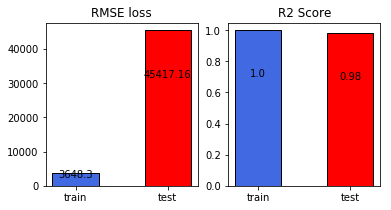

In [198]:
# split data into training, validation and test sets
X_trn,y_trn,X_test,y_test = two_split(df_drop,y)

m_ind.fit(X_trn,y_trn)
result= print_score(m_ind,X_trn,y_trn,X_test,y_test)
plot_score(m_ind, result,val=False)

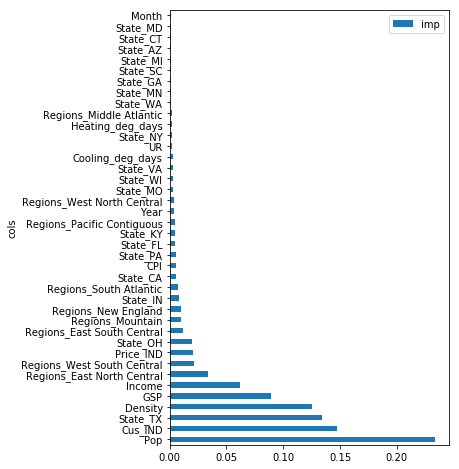

In [199]:
# calculate feature of importance
fi_ind = rf_feat_importance(m_ind, X_trn)
fi_ind.plot('cols','imp',kind='barh',figsize=(5,8))

In [200]:
# save train model 
pickle.dump(m_ind, open('model/ind_model.pkl', 'wb'))
#sort fi df by X_trn columns order 
fi_ind['cols'] = pd.Categorical(fi_ind['cols'], X_trn.columns)
fi_ind = fi_ind.sort_values('cols')
# save feature of importance 
fi_ind.to_csv('model/ind_feature_importance.csv',index=False)

TPOT

In [201]:
# load feature of importance 
fi_ind = pd.read_csv('model/ind_feature_importance.csv')
pre_col = 'Sale_IND'
df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
df = df[fi_ind['cols']]
X_trn,y_trn,X_test,y_test = two_split(df,y)
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_trn, y_trn)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline_ind.py')

Generation 1 - Current best internal CV score: -38093.29140860358
Generation 2 - Current best internal CV score: -38093.29140860358
Generation 3 - Current best internal CV score: -38093.29140860358
Generation 4 - Current best internal CV score: -38093.29140860358
Generation 5 - Current best internal CV score: -36032.79681123968

Best pipeline: ExtraTreesRegressor(StandardScaler(input_matrix), bootstrap=True, max_features=0.5, min_samples_leaf=2, min_samples_split=3, n_estimators=100)
-38753.97981665431


Implement TPOT model 

In [18]:
# load feature of importance 
fi_ind = pd.read_csv('model/ind_feature_importance.csv')
pre_col = 'Sale_IND'
df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
df = df[fi_ind['cols']]
X_trn,y_trn,X_test,y_test = two_split(df,y)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\pi

[4650.625231163675, 39641.79555260955, 0.998134941139997, 0.9846870108092161]


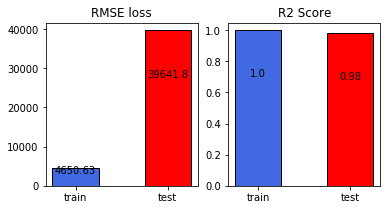

In [19]:
# implement TPOT model 
pipe_ind = make_pipeline(
    StandardScaler(),
    ExtraTreesRegressor(bootstrap=True, max_features=0.5, min_samples_leaf=2, min_samples_split=3, n_estimators=100)
)

pipe_ind.fit(X_trn,y_trn)
result = print_score(pipe_ind,X_trn,y_trn,X_test,y_test)
plot_score(pipe_ind, result,val=False)

In [20]:
#save the model 
joblib.dump(pipe_ind, 'model/pipe_ind.pkl')

['model/pipe_ind.pkl']

### Analyze Industrial Consumption Model<a id='ana_ind'></a>

In [328]:
#load the model 
pipe_ind = joblib.load('model/pipe_ind.pkl')
# load feature of importance 
fi_ind = pd.read_csv('model/ind_feature_importance.csv')

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


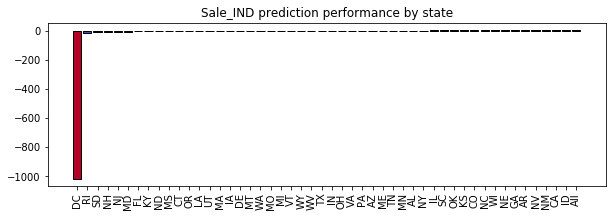

In [329]:
col = 'Sale_IND'
# analyzing the prediction indult by state 
ind_predict, ind_score = do_prediction(combine,pipe_ind,fi_ind['cols'],col)
ind_pred_df, score_state_ind = score_by_state(col,ind_predict,ind_score)

In [24]:
score_state_ind.head()

,State,Score,color
31,DC,-1015.458118,#b40426
13,RI,-17.832317,#3f53c6
15,SD,-10.958004,#3e51c5
4,NH,-9.010288,#3d50c3
5,NJ,-7.707395,#3d50c3


For the state with low prediction score, is there any geological relationship with the score ?

Text(0.5, 1.0, 'Sale_IND Model Performance by State')

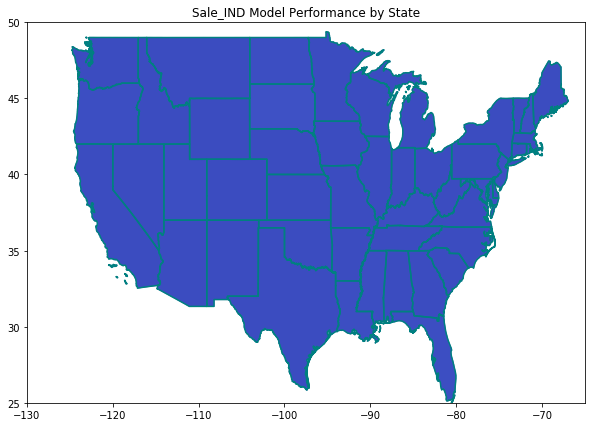

In [23]:
_,ax = plt.subplots(figsize=(10,7))

data = score_state_ind.drop(score_state_ind.index[-1])

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title(col + ' Model Performance by State')

Look at the time-series prediction

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


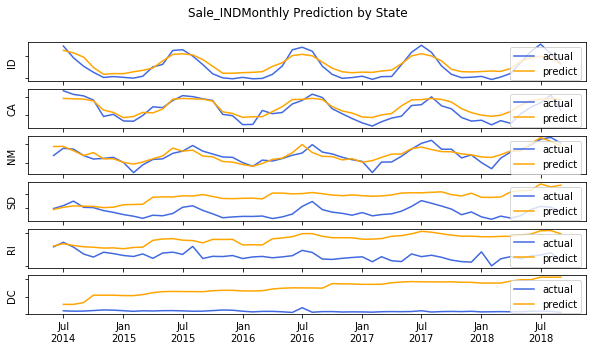

In [25]:
plot_predict(ind_pred_df,score_state_ind,col)

Any relationship between model performance by state and their features?

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
C:\Users\Benny\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Benny\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Benny\Anaconda3\envs\fastai\

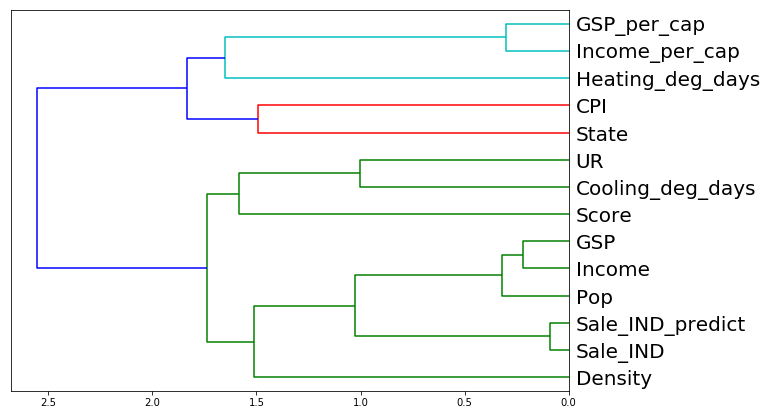

In [26]:
performance_feature(ind_pred_df,score_state_ind.drop('color',axis=1))

Model perform badly in DC, MD and NH, but no clear correlation between the score and the features. 

## Predicting Commercial Consumption <a id='com'></a>

In [139]:
#predict column 
pre_col = 'Sale_COM'
use_col = ['Year', 'Month', 'State','Cus_COM','Price_COM', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI','Regions','Density']

skip_col = [x for x in combine.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, COMicate the target column
# one hot encode the state column with 49 catergory
df, y, nas = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=49)
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)

In [140]:
# hyper parameter tuning and 
m_com = do_search(X_trn,y_trn)
# fit the model 
m_com.fit(X_trn,y_trn)

{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 27, 'max_depth': None, 'bootstrap': False} 0.9851739213747366


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=27, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=160, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[1124.6765015201827, 103857.68748307461, 0.9996448786721662, 0.9804996850769114]
[  1124.6765  103857.68748 268953.21327      0.99964      0.9805       0.95308]


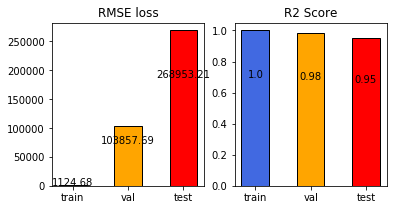

In [141]:
result= print_score(m_com,X_trn,y_trn,X_val,y_val)
# train, validation and test set score 
plot_score(m_com,result,val=True)

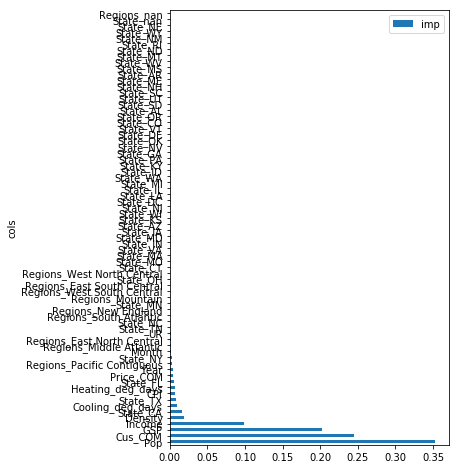

In [142]:
# calculate feature of importance
fi = rf_feat_importance(m_com, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

In [149]:
# drop features with low importance 
to_drop = fi[fi.imp <0.01].cols
df_drop = df.drop(to_drop,axis=1)

In [150]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop,y)
m_com = do_search(X_trn,y_trn)

m_com.fit(X_trn,y_trn)

{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': None, 'bootstrap': True} 0.9764779987929205


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[7871.099079448109, 117566.28441224835, 0.9975146674151845, 0.9779257595086561]
[  7871.09908 117566.28441 282152.11137      0.99751      0.97793      0.95078]


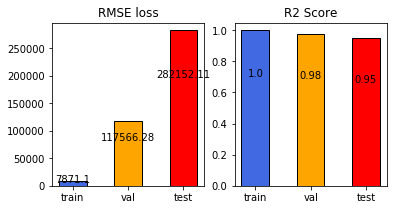

In [151]:
result = print_score(m_com,X_trn,y_trn,X_val,y_val)
# train, validation and test set score 
plot_score(m_com, result,val=True)

In [147]:
df_drop.columns

Index(['Year', 'Month', 'Price_COM', 'Cus_COM', 'Heating_deg_days',
       'Cooling_deg_days', 'Pop', 'Income', 'GSP', 'CPI', 'Density',
       'State_CA', 'State_FL', 'State_NY', 'State_TX',
       'Regions_Middle Atlantic', 'Regions_Pacific Contiguous'],
      dtype='object')

Try dropping highly correlated pair

In [152]:
pairs = ['Cus_COM','Pop']
for col in pairs:
    X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop.drop(col,axis=1),y)
    m_res = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
    m_res.fit(X_trn,y_trn)
    print('drop ',col)
    result = print_score(m_res,X_trn,y_trn,X_val,y_val)

drop  Cus_COM
[18924.1160982954, 199686.9134925936, 0.9940246308802375, 0.9625067937338806]
drop  Pop
[20519.0062608305, 237224.3782268371, 0.9935210376145269, 0.9554587609741355]


Cannot drop either "Cus_COM" nor "Pop"

In [153]:
pairs = ['GSP','Income']
for col in pairs:
    X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop.drop(col,axis=1),y)
    m_res = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
    m_res.fit(X_trn,y_trn)
    print('drop ',col)
    result = print_score(m_res,X_trn,y_trn,X_val,y_val)

drop  GSP
[19021.994077587806, 138188.59664664764, 0.9939937254972896, 0.9740537150528369]
drop  Income
[19349.68851623084, 139142.15297836802, 0.9938902546023102, 0.973874675357114]


Can cannot drop either 'GSP', 'Income'

[7754.299307215574, 147606.45222861302, 0.9979372983534576, 0.9742511484914038]


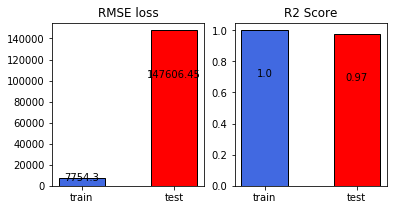

In [154]:
# split data into training, validation and test sets
X_trn,y_trn,X_test,y_test = two_split(df_drop,y)

m_com.fit(X_trn,y_trn)
result = print_score(m_com,X_trn,y_trn,X_test,y_test)
plot_score(m_com, result,val=False)

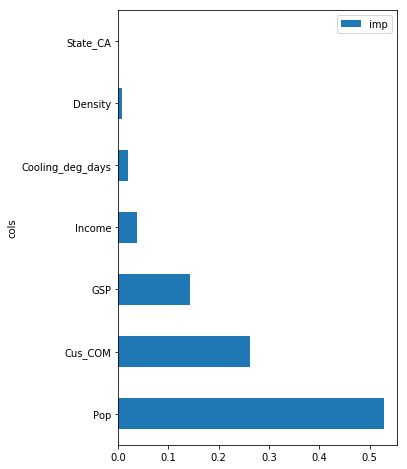

In [155]:
# calculate feature of importance
fi_com = rf_feat_importance(m_com, X_trn)
fi_com.plot('cols','imp',kind='barh',figsize=(5,8))

In [156]:
# save train model 
pickle.dump(m_com, open('model/com_model.pkl', 'wb'))

#sort fi df by X_trn columns order 
fi_com['cols'] = pd.Categorical(fi_com['cols'], X_trn.columns)
fi_com = fi_com.sort_values('cols')
# save feature of importance 
fi_com.to_csv('model/com_feature_importance.csv',index=False)

**TPOT**

In [159]:
# load feature of importance 
fi_com = pd.read_csv('model/com_feature_importance.csv')
pre_col = 'Sale_COM'
df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
df = df[fi_com['cols']]
X_trn,y_trn,X_test,y_test = two_split(df,y)
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_trn, y_trn)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline_com.py')

Generation 1 - Current best internal CV score: -77025.80304041655
Generation 2 - Current best internal CV score: -77025.80304041655
Generation 3 - Current best internal CV score: -75579.95804876657
Generation 4 - Current best internal CV score: -71417.58724213748
Generation 5 - Current best internal CV score: -70976.85821676331

Best pipeline: ExtraTreesRegressor(CombineDFs(input_matrix, input_matrix), bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=1, min_samples_split=7, n_estimators=100)


C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


-69628.54051400536


In [162]:
# load feature of importance 
fi_com = pd.read_csv('model/com_feature_importance.csv')
pre_col = 'Sale_COM'
df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
df = df[fi_com['cols']]
X_trn,y_trn,X_test,y_test = two_split(df,y)

[10858.223055006818, 66025.00110253098, 0.9971116314077216, 0.9884824279455554]


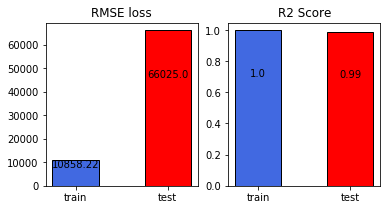

In [166]:
pipe_com = make_pipeline(
    make_union(
        FunctionTransformer(copy,validate=True),
        FunctionTransformer(copy,validate=True)
    ),
    ExtraTreesRegressor(bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=1, min_samples_split=7, n_estimators=100)
)


pipe_com.fit(X_trn,y_trn)
result = print_score(pipe_com,X_trn,y_trn,X_test,y_test)
plot_score(pipe_com, result,val=False)

In [167]:
#save the model 
joblib.dump(pipe_com, 'model/pipe_com.pkl')

['model/pipe_com.pkl']

### Analyze Commercial Consumption Model<a id='ana_com'></a>

In [168]:
#load the model 
pipe_com = joblib.load('model/pipe_com.pkl')
# load feature of importance 
fi_com = pd.read_csv('model/com_feature_importance.csv')

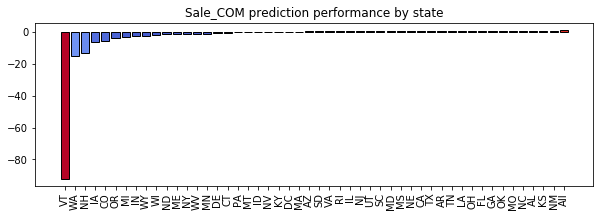

In [169]:
col = 'Sale_COM'
# analyzing the prediction comult by state 
com_predict, com_score = do_prediction(combine,pipe_com,fi_com['cols'],col)
com_pred_df, score_state_com = score_by_state(col,com_predict,com_score)

For the state with low prediction score, is there any geological relationship with the score ?

Text(0.5, 1.0, 'Sale_COMModel Performance by State')

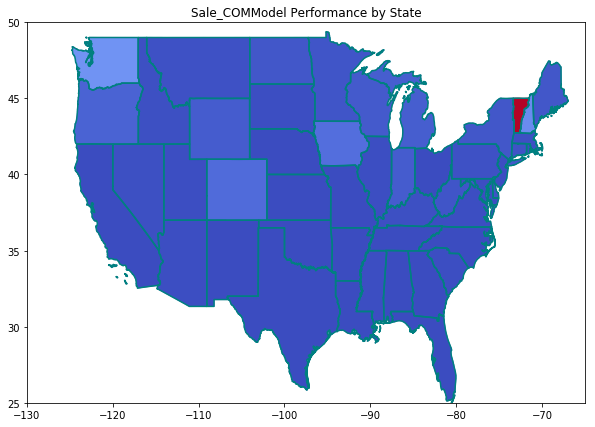

In [170]:
_,ax = plt.subplots(figsize=(10,7))

data = score_state_com.drop(score_state_com.index[-1])

for state in data['State'].values:
    fillcolor = data[data['State']==state]['color'].values[0]
    draw_state(ax, state,cfill=fillcolor,cedge='teal',alphafill=1,alphaedge=1)

plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title(col + 'Model Performance by State')

Look at the time-series prediction

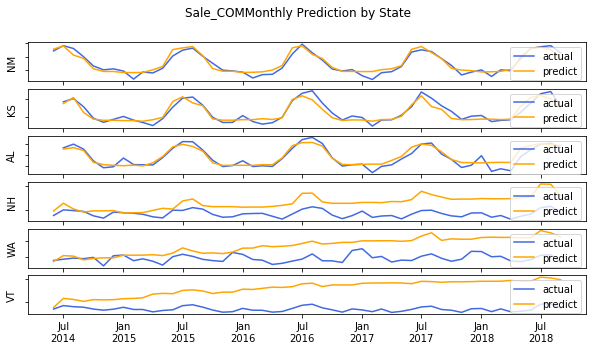

In [171]:
plot_predict(com_pred_df,score_state_com,col)

Any relationship between model performance by state and their features?

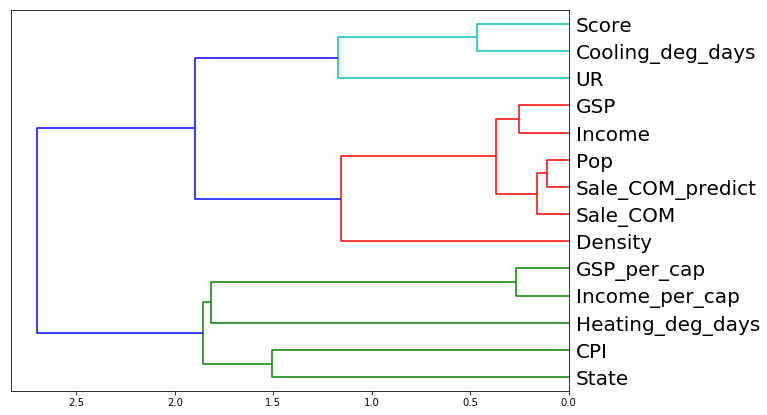

In [173]:
performance_feature(com_pred_df,score_state_com.drop('color',axis=1))

# Combine models and Analyze models performance by state<a id='analyze'></a>

I obtained are three trained ML models and three csv files with the features and the corresponding importance. I use these models to predict the total electricity consumption by state. Then analyze the model performance by state, and look at the time series prediction.

In [16]:
!dir model

 Volume in drive C is Windows
 Volume Serial Number is FC06-B52C

 Directory of C:\Users\Benny\Documents\Fern\energy\model

05/16/2019  10:43 AM    <DIR>          .
05/16/2019  10:43 AM    <DIR>          ..
05/16/2019  03:31 PM               217 com_feature_importance.csv
05/16/2019  03:31 PM        49,451,517 com_model.pkl
05/16/2019  10:03 PM             1,375 ind_feature_importance.csv
05/16/2019  10:03 PM        73,640,677 ind_model.pkl
05/16/2019  04:21 PM        33,604,663 pipe_com.pkl
05/17/2019  08:20 AM        47,442,479 pipe_ind.pkl
05/16/2019  10:31 AM        30,592,801 pipe_res.pkl
05/16/2019  10:23 AM               303 res_feature_importance.csv
05/13/2019  10:26 PM        64,763,397 res_model.pkl
               9 File(s)    299,497,429 bytes
               2 Dir(s)  29,699,731,456 bytes free


In [308]:
# load model
m_res = joblib.load(open('model/pipe_res.pkl', 'rb'))
m_ind = joblib.load(open('model/pipe_ind.pkl', 'rb'))
m_com = joblib.load(open('model/pipe_com.pkl', 'rb'))

In [309]:
# load feature of importance 
fi_res = pd.read_csv('model/res_feature_importance.csv')
fi_ind = pd.read_csv('model/ind_feature_importance.csv')
fi_com = pd.read_csv('model/com_feature_importance.csv')

Model features and their importance. 

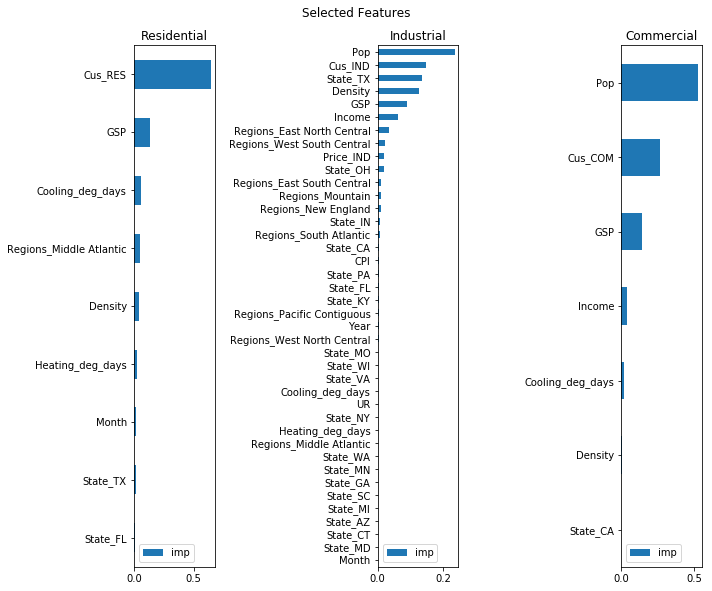

In [379]:
fig, ax = plt.subplots(1,3, figsize=(10,8))

fi_res.sort_values('imp').plot('cols','imp',kind='barh',ax=ax[0])
ax[0].set_title('Residential')
ax[0].set_ylabel(None)
fi_ind.sort_values('imp').plot('cols','imp',kind='barh',ax=ax[1])
ax[1].set_title('Industrial')
ax[1].set_ylabel(None)
fi_com.sort_values('imp').plot('cols','imp',kind='barh',ax=ax[2])
ax[2].set_title('Commercial')
ax[2].set_ylabel(None)

fig.suptitle('Selected Features',y=1.02)
plt.tight_layout()

In [310]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Year-Month', 'Density', 'Sale_ALL_no_OTH'],
      dtype='object')

In [311]:
# prediction for each sector
res_predict, res_score = do_prediction(combine,m_res,fi_res['cols'],'Sale_RES')
ind_predict, ind_score = do_prediction(combine,m_ind,fi_ind['cols'],'Sale_IND')
com_predict, com_score = do_prediction(combine,m_com,fi_com['cols'],'Sale_COM')

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.5, 1.0, 'R-square for each sector')

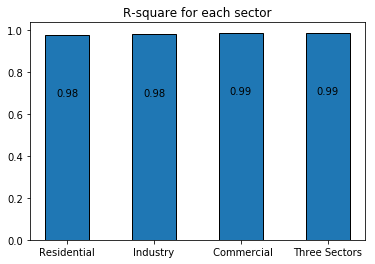

In [312]:
test_idxs = len(res_predict)
y_all_test = combine.iloc[-len(res_predict):]['Sale_ALL_no_OTH']
# over all prediction
all_predict = res_predict+ind_predict+com_predict
all_score = r2_score(y_all_test,all_predict)

x = ['Residential', 'Industry',' Commercial', 'Three Sectors']
y = [res_score,ind_score,com_score, all_score]
plt.bar(x,height=y, edgecolor ='black',width=0.5)

for i in range(len(y)):
        plt.text(s=f'{y[i].round(2)}',x=i, y=y[i].round(2)*0.7,horizontalalignment='center')
plt.title('R-square for each sector')    

In [166]:
# analyzing the prediction result
data = combine.iloc[-len(res_predict):][['Year-Month','State','Regions','Sale_RES','Sale_IND','Sale_COM','Sale_ALL_no_OTH']]
data['Pred_RES'] = res_predict
data['Pred_IND'] = ind_predict
data['Pred_COM'] = com_predict
data['Pred_ALL_no_OTH'] = all_predict

In [167]:
# save prediction and actual result for the test data 
data.to_csv('model/prediction.csv',index=False)

In [281]:
data = pd.read_csv('model/prediction.csv')

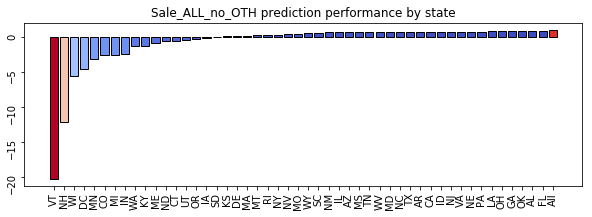

In [335]:
# model performance by state for all sectors
all_pred_df, score_state_all = score_by_state('Sale_ALL_no_OTH',all_predict,all_score)

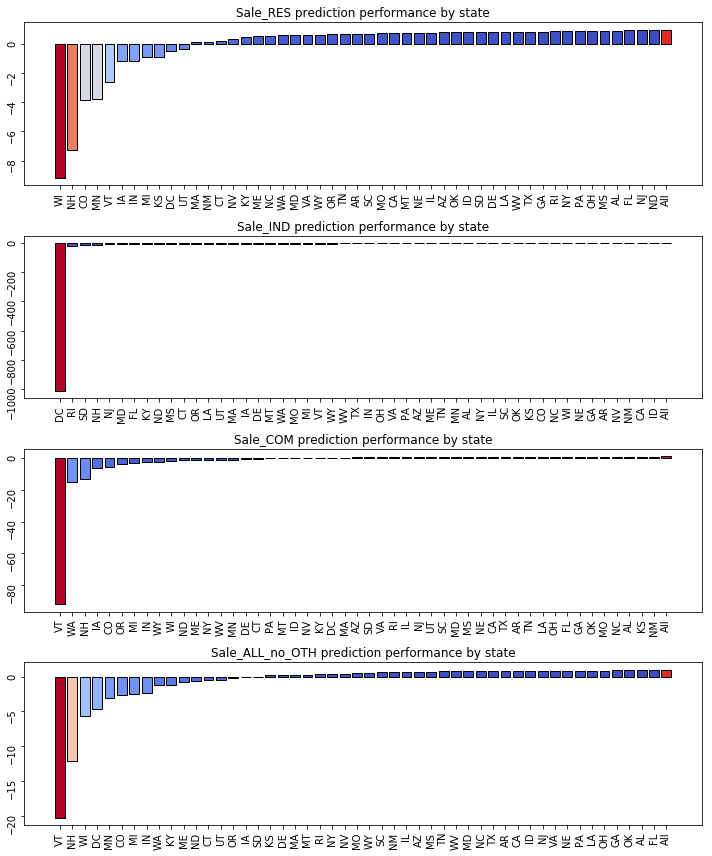

In [336]:
_,ax = plt.subplots(4,1,figsize=(10, 12))

res_pred_df, score_state_res = score_by_state('Sale_RES',res_predict,res_score,ax=ax[0])
ind_pred_df, score_state_ind = score_by_state('Sale_IND',ind_predict,ind_score,ax=ax[1])
com_pred_df, score_state_com = score_by_state('Sale_COM',com_predict,com_score,ax=ax[2])
all_pred_df, score_state_all = score_by_state('Sale_ALL_no_OTH',all_predict,all_score,ax=ax[3])
plt.tight_layout()

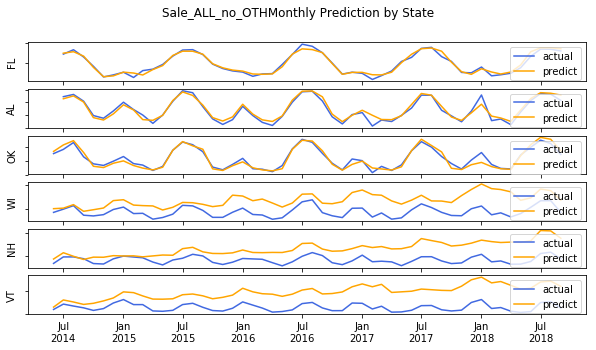

In [322]:
plot_predict(all_pred_df,score_state_all,'Sale_ALL_no_OTH')

In [323]:
state_location = pd.read_html('https://inkplant.com/code/state-latitudes-longitudes')[0]
state_location['State'] = state_location['State'].replace(to_replace=us_state_abbrev)
score_state_all = score_state_all.merge(state_location,on='State')

In [325]:
correct = score_state_all[score_state_all['Score']>0.5].sort_values('Score',ascending=False)
correct = correct.iloc[:15]
incorrect = score_state_all[score_state_all['Score']<=0.5]
incorrect = incorrect.iloc[:15]

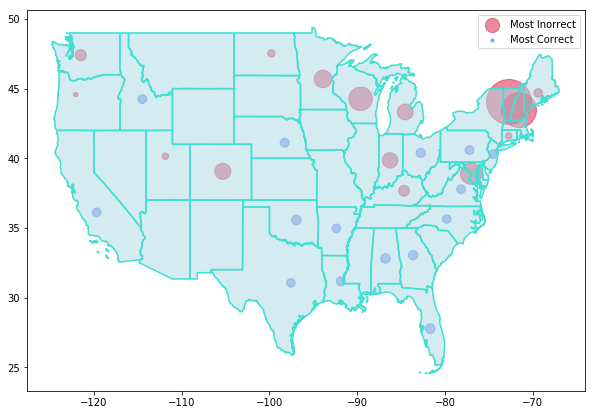

In [326]:
_,ax = plt.subplots(figsize=(10,7))

for state in combine['State'].unique():
    draw_state(ax, state)
    
plt.scatter(x=correct['Longitude'],y=correct['Latitude'],s=correct['Score']*100,c='royalblue',alpha=0.5,label='Most Correct')
plt.scatter(x=incorrect['Longitude'],y=incorrect['Latitude'],s=np.abs(incorrect['Score'])*100,c='crimson',alpha=0.5,label='Most Incorrect')

marker1 = plt.scatter([],[], s=np.abs(incorrect['Score']).max()*10,c='crimson',alpha=0.5)
marker2 = plt.scatter([],[], s=correct['Score'].max()*10,c='royalblue',alpha=0.5)
plt.legend(handles=[marker1,marker2],labels=['Most Inorrect','Most Correct'])

plt.show()

Incorrect states are in the north east and mid-west. We can try creating separate models for these states.

# Compare with STEO 

STEO data is group by regions. 

In [168]:
# load prediction result
pred_df = pd.read_csv('model/prediction.csv')
pred_df['Year-Month'] = pd.to_datetime(pred_df['Year-Month'])

# load steo 
steo = pd.read_csv(cleanfolder+'steo.csv')
steo['Year-Month'] = pd.to_datetime(steo['Year-Month'])
steo.head()

,Regions,Year-Month,STEO_Sale_COM,STEO_Sale_IND,STEO_Sale_RES,STEO_Sale_All,Year,Month,STEO_Sale_ALL_no_OTH
0,East North Central,2015-01-01,15841.0,16337.0,19282.0,51522.0,2015,1,51460.0
1,East South Central,2015-01-01,7564.0,8649.0,12245.0,28458.0,2015,1,28458.0
2,Middle Atlantic,2015-01-01,13454.0,5952.0,13299.0,33077.0,2015,1,32705.0
3,Mountain,2015-01-01,7502.0,6789.0,8246.0,22537.0,2015,1,22537.0
4,New England,2015-01-01,4526.0,1488.0,4774.0,10850.0,2015,1,10788.0


In [169]:
# group by Regions
region_df = pred_df.groupby(['Year-Month','Regions'],as_index=False).sum()
region_df = region_df.merge(steo, on = ['Year-Month','Regions'])
region_df = region_df.set_index('Year-Month')
pred_df = pred_df.set_index('Year-Month')
region_df.columns

Index(['Regions', 'Sale_RES', 'Sale_IND', 'Sale_COM', 'Sale_ALL_no_OTH',
       'Pred_RES', 'Pred_IND', 'Pred_COM', 'Pred_ALL_no_OTH', 'STEO_Sale_COM',
       'STEO_Sale_IND', 'STEO_Sale_RES', 'STEO_Sale_All', 'Year', 'Month',
       'STEO_Sale_ALL_no_OTH'],
      dtype='object')

Plot state prediction, actual and STEO for that regions

In [339]:
# pick a sector 'RES','COM','IND', 'ALL_no_OTH'
sector = 'RES'
# pick a state abbreviation 
state = 'CA'
cols = ['Sale_'+sector,'Pred_'+sector, 'STEO_Sale_'+sector]

In [340]:
# select the data we want to plot
data1 = pred_df[pred_df['State']==state]
data1.set_index('Year-Month',inplace=True)
region = data1['Regions'].unique()[0]
data2 = region_df[region_df['Regions']==region]
data2.set_index('Year-Month',inplace=True)

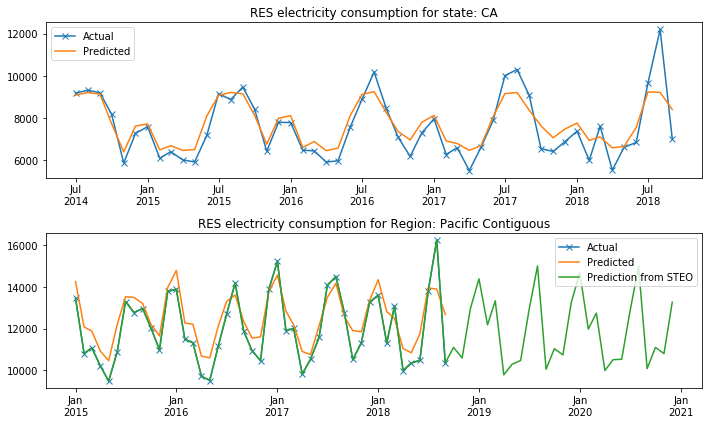

In [341]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig,ax = plt.subplots(2,1,figsize=(10,6))

ax[0].plot(data1[cols[0]],marker='x')
ax[0].plot(data1[cols[1]])
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
ax[0].legend(['Actual','Predicted'])
ax[0].set_title(sector +' electricity consumption for state: '+state)


ax[1].plot(data2[cols[0]],marker='x')
ax[1].plot(data2[cols[1:]])
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
ax[1].legend(['Actual','Predicted','Prediction from STEO'])
ax[1].set_title(sector +' electricity consumption for Region: '+ region)

plt.tight_layout()

## Interactive Plot in Bokeh 

In [174]:
from bokeh.io import output_file, output_notebook, show
from bokeh.models import ( ColumnDataSource, Circle, BasicTicker, 
                          Slider, DateRangeSlider, Legend)

from bokeh.plotting import figure, show, output_file
from bokeh.layouts import widgetbox, row, column, gridplot
from bokeh.models.widgets import  Select

output_notebook()

Loading BokehJS ...

A simple plot in bokeh (this is a prototype for an app). I have two datasets for state and regions 

In [175]:
pred_df.columns

Index(['State', 'Regions', 'Sale_RES', 'Sale_IND', 'Sale_COM',
       'Sale_ALL_no_OTH', 'Pred_RES', 'Pred_IND', 'Pred_COM',
       'Pred_ALL_no_OTH'],
      dtype='object')

In [259]:
# load prediction result
pred_df = pd.read_csv('model/prediction.csv')
pred_df['Year-Month'] = pd.to_datetime(pred_df['Year-Month'])

# load steo 
steo = pd.read_csv(cleanfolder+'steo.csv')
steo['Year-Month'] = pd.to_datetime(steo['Year-Month'])

# group by Regions and merge with prediction data
region_df = pred_df.groupby(['Year-Month','Regions'],as_index=False).sum()
region_df = region_df.merge(steo, on = ['Year-Month','Regions'],how='right')

In [272]:
# pick a sector 'RES','COM','IND', 'ALL_no_OTH'
sector = 'ALL_no_OTH'
#column to plot
cols = ['Sale_'+sector,'Pred_'+sector, 'STEO_Sale_'+sector]
# pick a state abbreviation 
state = 'CA'

# select the data dfs to plot
data1 = pred_df[pred_df['State']==state]
data1 = data1[cols[:2]+['Year-Month','Regions']]
data1.columns = ['col1','col2','Year-Month','Regions']
source1 = ColumnDataSource(data1)
region = data1['Regions'].unique()[0]
data2 = region_df[region_df['Regions']==region]
data2 = data2[cols+['Year-Month']]
data2.columns = ['col1','col2','col3','Year-Month']
source2 = ColumnDataSource(data2)

In [273]:
colors = ['#2c7fb8','#fec44f','#c51b8a']

p2 = figure(plot_width=700, plot_height=250, x_axis_type="datetime",tools="pan,box_zoom,reset",toolbar_location='above')
r2 = p2.line(source=source2, x='Year-Month', y='col1', color=colors[0],line_width=2)
r3 = p2.line(source=source2, x='Year-Month', y='col2', color=colors[1],line_width=2)
r4 =p2.line(source=source2, x='Year-Month', y='col3', color=colors[2],line_width=2,line_dash=[4, 4])
p2.title.text = sector +' electricity consumption for Region: '+ region
p2.yaxis.axis_label = "(million kWh)"

legend = Legend(items=[
    ("Actual"   , [r2]),
    ("Predicted" , [r3]),
    ("STEO Prediction",[r4])
], location="center")

p2.add_layout(legend,'right')

p1 = figure(plot_width=700, plot_height=250, x_axis_type="datetime",x_range=p2.x_range,tools="pan,box_zoom,reset",toolbar_location='above')

r0 = p1.line(source=source1, x='Year-Month', y='col1', color=colors[0],line_width=2)
r1 = p1.line(source=source1, x='Year-Month', y='col2', color=colors[1],line_width=2)
p1.title.text = sector +' electricity consumption for state: '+state
p1.yaxis.axis_label = "(million kWh)"

legend = Legend(items=[
    ("Actual"   , [r0]),
    ("Predicted" , [r1]),
], location="center")

p1.add_layout(legend,'right')


layout = column(p1,p2)
show(layout)

In [185]:
import json

# dictionary to map state name to state abbreviation
with open('us_state_abbrev.json') as f:
    us_state_abbrev = json.loads(f.read())

state_dict = us_state_abbrev 
state_dict.pop('Hawaii',None)
state_names = [*state_dict]
# dictionary to map sector names to their abbreviations
sector_dict = {'Residential':'RES',
               'Industrial':'IND', 'Commercial':'COM', 'Total':'ALL_no_OTH'}

In [256]:
def get_source(sector_name,state_name):
    '''
    return two bokeh columnar data sources for that sector, state and region
    '''
    sector = sector_dict[sector_name]
    #column to plot
    cols = ['Sale_'+sector,'Pred_'+sector, 'STEO_Sale_'+sector]
    # pick a state abbreviation 
    state = state_dict[state_name]

    # select the data dfs to plot
    data1 = pred_df[pred_df['State']==state]
    data1 = data1[cols[:2]+['Year-Month','Regions']]
    data1.columns = ['col1','col2','Year-Month','Regions']
    source1 = ColumnDataSource(data1)
    region = data1['Regions'].unique()[0]
    data2 = region_df[region_df['Regions']==region]
    data2 = data2[cols+['Year-Month']]
    data2.columns = ['col1','col2','col3','Year-Month']
    source2 = ColumnDataSource(data2)
    
    return ColumnDataSource(data1), ColumnDataSource(data2), region
    

In [274]:
def plot_prediction(doc):
     
    # default sector and state
    sector_name = 'Residential'
    state_name = 'Alabama'
    source1, source2, region = get_source(sector_name,state_name)
    
    #plot state 
    p1 = figure(plot_width=700, plot_height=250, x_axis_type="datetime",tools="pan,box_zoom,reset",toolbar_location='above')
    r0 = p1.line(source=source1, x='Year-Month', y='col1', color=colors[0],line_width=2)
    r1 = p1.line(source=source1, x='Year-Month', y='col2', color=colors[1],line_width=2)
    p1.title.text = sector_name +' electricity consumption for state: '+ state_name
    p1.yaxis.axis_label = "(million kWh)"

    legend = Legend(items=[
        ("Actual"   , [r0]),
        ("Predicted" , [r1]),
    ], location="center")

    p1.add_layout(legend,'right')
    
    #plot region
    p2 = figure(plot_width=700, plot_height=250, x_axis_type="datetime",x_range=p1.x_range,tools="pan,box_zoom,reset",toolbar_location='above')
    r2 = p2.line(source=source2, x='Year-Month', y='col1', color=colors[0],line_width=2)
    r3 = p2.line(source=source2, x='Year-Month', y='col2', color=colors[1],line_width=2)
    r4 =p2.line(source=source2, x='Year-Month', y='col3', color=colors[2],line_width=2,line_dash=[4, 4])
    p2.title.text = sector_name +' electricity consumption for Region: '+ region
    p2.yaxis.axis_label = "(million kWh)"

    legend = Legend(items=[
        ("Actual"   , [r2]),
        ("Predicted" , [r3]),
        ("STEO Prediction",[r4])
    ], location="center")

    p2.add_layout(legend,'right')

    def callback_sector(attr,old,new):
        
        global state_name, sector_name, region
        sector_name = new 
        temp1, temp2, region = get_source(sector_name,state_name)
        # change data
        source1.data = temp1.data
        source2.data = temp2.data
        # change title
        p1.title.text = sector_name +' electricity consumption for state: '+ state_name
        p2.title.text = sector_name +' electricity consumption for Region: '+ region
  
        
    def callback_state(attr,old,new):
        
        global state_name, sector_name, region
        state_name = new
        temp1, temp2, region = get_source(sector_name,state_name)
        # change data
        source1.data = temp1.data
        source2.data = temp2.data
        # change title
        p1.title.text = sector_name +' electricity consumption for state: '+ state_name
        p2.title.text = sector_name +' electricity consumption for Region: '+ region
    
    # make drop down menu
    select_sector = Select(title='Sector:', value=[*sector_dict][0], options=[*sector_dict])
    select_sector.on_change('value', callback_sector)
    
    select_state = Select(title='State:', value=[*state_dict][0], options=[*state_dict])
    select_state.on_change('value', callback_state)
    
    layout = column(widgetbox(select_sector,select_state),p1,p2)
    doc.add_root(layout)

In [275]:
show(plot_prediction,notebook_url="http://localhost:8888")